<div style="display: flex; justify-content: space-between; align-items: center;">
  <span>📅 11/11/2025</span>
    <p align="right">
    <a href="https://colab.research.google.com/github/tripathysagar/NanoTransformer/blob/main/nbs/07_DistilationWeightInit.ipynb" target="_blank">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    </p>
</div>

**Aim** : Build a small language model that generates bash commands from natural language descriptions, optimized for CPU execution. Rather than training from scratch (which requires extensive data, compute, and time for tokenization, pretraining, etc.), we use knowledge distillation to extract this specialized capability from a larger teacher model. The teacher model is Qwen/Qwen2.5-Coder-0.5B-Instruct, chosen for its instruction-following and coding abilities. For training data, we use the westenfelder/NL2SH-ALFA dataset, containing 40,639 pairs of natural language queries and corresponding bash commands.


**Distillation Approach** : Think of a Swiss Army knife with multiple tools for different tasks. Our goal is to extract a single, specialized tool from this multi-purpose instrument. The original instruction-tuned model is proficient at many coding tasks, including bash command generation. Through distillation, we create a smaller, focused model that excels specifically at translating natural language to bash commands, while discarding unnecessary capabilities to achieve a compact, efficient design.

**Motivation** : While users can traditionally consult man pages or online AI platforms like ChatGPT for bash command assistance, several real-world scenarios create barriers to these approaches. Many corporate and enterprise environments block access to external AI platforms due to security policies, leaving developers without intelligent command-line assistance. In air-gapped systems, research facilities, and offline environments, internet connectivity is unavailable, making cloud-based AI tools inaccessible.

Beyond accessibility, privacy concerns are paramount when working with sensitive data or proprietary workflows—sharing command queries with external services risks exposing confidential information about internal systems and processes. Additionally, network latency for API calls can disrupt workflow efficiency, especially when users need quick command suggestions during active development or system administration tasks.

This project addresses these challenges by distilling a specialized, lightweight bash command generation model from a larger instruction-following model (Qwen2.5-Coder-0.5B-Instruct). The resulting model can be deployed locally on minimal CPU resources, providing instant, private, and cost-effective bash command assistance without external dependencies or API fees.

In [ ]:
#|hide
!uv pip install -q trackio graphviz Pillow matplotlib transformers torch datasets numpy

In [ ]:
#|hide
from graphviz import Digraph
from PIL import Image
import io
import matplotlib.pyplot as plt
import re

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
elif torch.mps.is_available():
    device = torch.device("mps")
    try:
        _ = torch.zeros(1, device=device, dtype=torch.bfloat16)
        dtype = torch.bfloat16
    except Exception:
        dtype = torch.float16
else:
    device = torch.device("cpu")
    dtype = torch.float32

device, dtype

(device(type='cuda'), torch.bfloat16)

## Teacher Model: Qwen2.5-Coder-0.5B-Instruct

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM
local_files_only = False
# Load tokenizer first (lightweight)
model_name = "Qwen/Qwen2.5-Coder-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    local_files_only=local_files_only
    )
teacher_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype =  dtype,
    device_map =  "cpu",
    low_cpu_mem_usage = True,
    trust_remote_code = True,
    local_files_only=local_files_only
)
teacher_model

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2

In [5]:
len(tokenizer.vocab)

151665

In [6]:
teacher_model.model.embed_tokens.weight in teacher_model.lm_head.weight

True

The teacher model is a decoder only text to text model. It have 24 decoder block stack on top of each other. Each block uses RMS norm. The language model head `lm_head` which is used for generate logits from the input share the same weight as `embed_tokens`(weight tying).


In [7]:
teacher_model.config

Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "dtype": "bfloat16",
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention"
  ],
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_

## Student Model Architecture & Initialization

Lets talk about how we can shorten the teacher model.

1. using a smaller tokenizer, which will shorten the vocab size. But this way comes with overhead of retraing the tokenize
1. major part of the computation is done in the decoder blocks. We can use smaller no of block to achive the task
1. using samller no of params in the decoder block, here the the depth of the model can help us learning complex representation

For simplicity and symetricity we will go with option 2.

- The same vocabulary/tokenizer (151,665 tokens)
- The same hidden dimension (896)
- The same architecture per layer (attention heads, MLP structure)

The sudent model is a vertical slice of the teacher model, which should make knowledge transfer more straightforward since each layer in the student can potentially learn from its corresponding layer in the teacher.

We will use a DISTIL_FACTOR=6 i.e. only using 4 decoder blocks. We will use AutoConfig attribute of the teacher model to create the new model.

In [8]:
DISTIL_FACTOR = 6
NO_HIDDEN = teacher_model.config.num_hidden_layers // DISTIL_FACTOR

assert teacher_model.config.num_hidden_layers % DISTIL_FACTOR == 0
DISTIL_FACTOR, NO_HIDDEN

(6, 4)

### init
Rather than randomly init weights, there are two initialization strategies that I experimented with:

1. **Simple copy**: as the no of decoder layer in the model is trimmed down by the factor of `DISTIL_FACTOR`, we can just copy the weights from `k * DISTIL_FACTOR` block.  Select every 6th layer from the teacher (layers 0, 6, 12, 18) to initialize your 4 student layers.
1. **Fused layers**: we will take the avg of weights from multiple  deocder blocks(e.g., average layers 0-5 for student layer 0, layers 6-11 for student layer 1, etc.).


Below digram shows each in details.

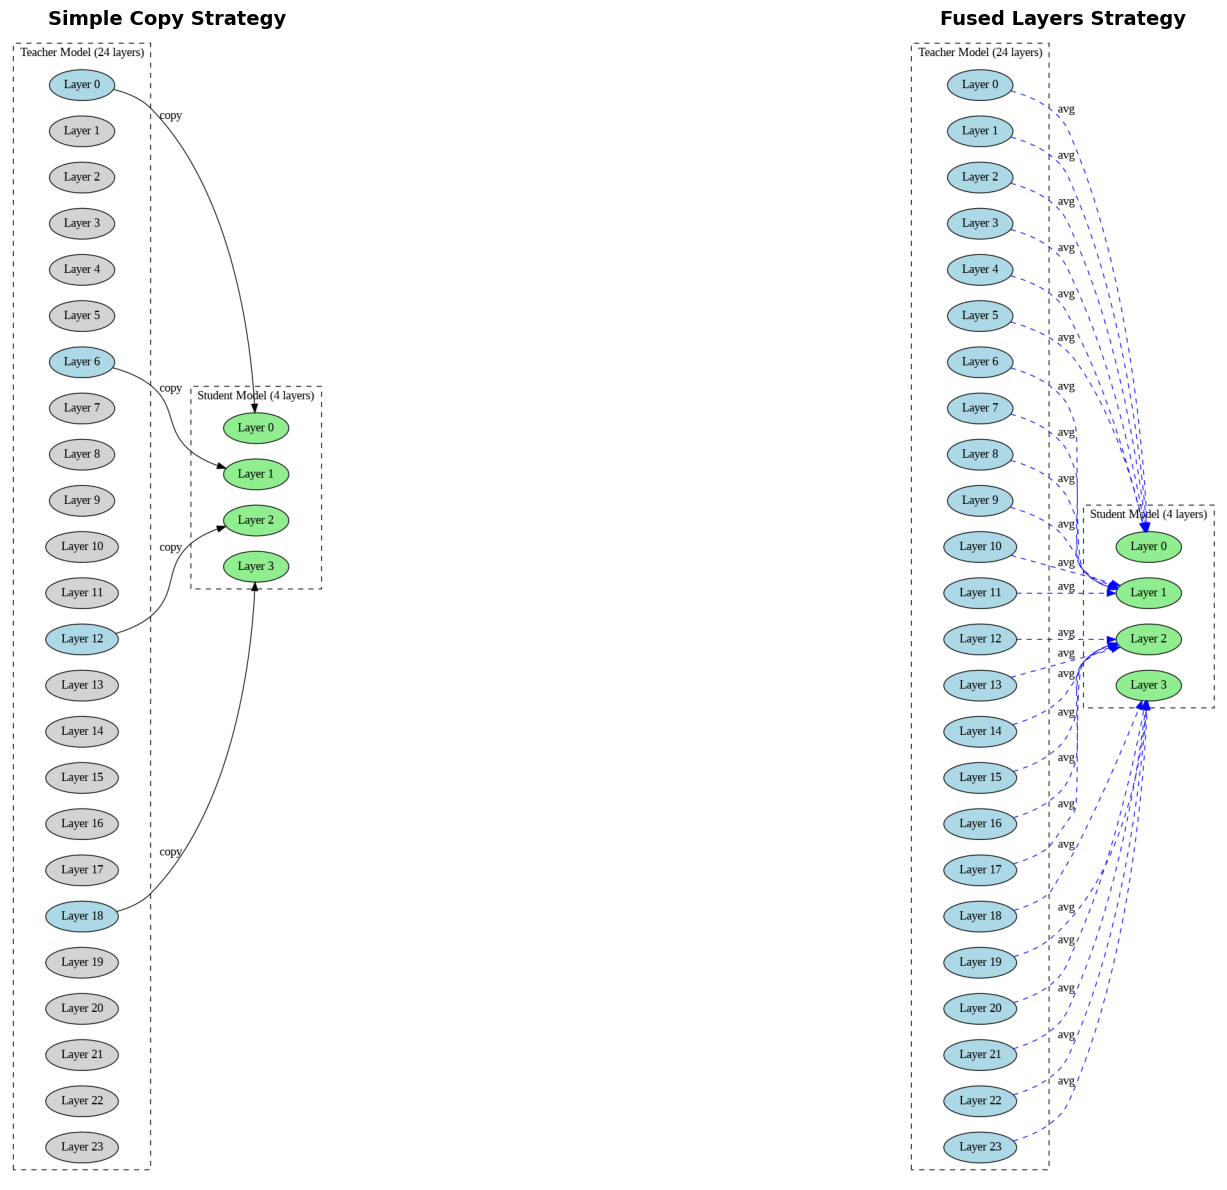

In [ ]:
#|echo: false

def draw_simple_copy():
    dot = Digraph(comment='Simple Copy Strategy')
    dot.attr(rankdir='LR')

    # Teacher layers
    with dot.subgraph(name='cluster_teacher') as c:
        c.attr(label='Teacher Model (24 layers)', style='dashed')
        for i in range(24):
            if i % DISTIL_FACTOR == 0:
                c.node(f'T{i}', f'Layer {i}', style='filled', fillcolor='lightblue')
            else:
                c.node(f'T{i}', f'Layer {i}', style='filled', fillcolor='lightgray')

    # Student layers
    with dot.subgraph(name='cluster_student') as c:
        c.attr(label='Student Model (4 layers)', style='dashed')
        for i in range(NO_HIDDEN):
            c.node(f'S{i}', f'Layer {i}', style='filled', fillcolor='lightgreen')

    # Connections - copy from k * DISTIL_FACTOR
    for i in range(NO_HIDDEN):
        dot.edge(f'T{i * DISTIL_FACTOR}', f'S{i}', label='copy')

    return dot

def draw_fused_layers():
    # Fused Layers Strategy
    dot2 = Digraph(comment='Fused Layers Strategy')
    dot2.attr(rankdir='LR')

    # Teacher layers grouped
    with dot2.subgraph(name='cluster_teacher') as c:
        c.attr(label='Teacher Model (24 layers)', style='dashed')
        for i in range(24):
            c.node(f'T{i}', f'Layer {i}', style='filled', fillcolor='lightblue')

    # Student layers
    with dot2.subgraph(name='cluster_student') as c:
        c.attr(label='Student Model (4 layers)', style='dashed')
        for i in range(NO_HIDDEN):
            c.node(f'S{i}', f'Layer {i}', style='filled', fillcolor='lightgreen')

    # Connections - average from groups
    for i in range(NO_HIDDEN):
        for j in range(DISTIL_FACTOR):
            teacher_idx = i * DISTIL_FACTOR + j
            dot2.edge(f'T{teacher_idx}', f'S{i}', label='avg', color='blue', style='dashed')

    return dot2

def show_init_diagram():
    dot1 = draw_simple_copy()
    dot2 = draw_fused_layers()

    # Render to PNG
    img1 = Image.open(io.BytesIO(dot1.pipe(format='png')))
    img2 = Image.open(io.BytesIO(dot2.pipe(format='png')))

    # Display side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

    ax1.imshow(img1)
    ax1.axis('off')
    ax1.set_title('Simple Copy Strategy', fontsize=14, fontweight='bold')

    ax2.imshow(img2)
    ax2.axis('off')
    ax2.set_title('Fused Layers Strategy', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

show_init_diagram()

In [10]:
def get_layer( i, j):
  """
  Return list state dict values of decoder block
  """
  return list(
    teacher_model.model.layers[i * DISTIL_FACTOR + j].state_dict().values())

In [11]:
from transformers import AutoConfig
from copy import deepcopy


def get_student_model(teacher_config:AutoConfig, fused_layers=True):
    student_config = deepcopy(teacher_config)

    # student config
    student_config.num_hidden_layers = NO_HIDDEN
    student_config.layer_types = student_config.layer_types[:NO_HIDDEN]
    student_config.max_window_layers = NO_HIDDEN

    # init student
    student_model = AutoModelForCausalLM.from_config(student_config)
    student_model = student_model.to(dtype)

    # init token embeding
    student_model.model.embed_tokens.load_state_dict(
        teacher_model.model.embed_tokens.state_dict())

    # init lm head
    student_model.lm_head.load_state_dict(
        teacher_model.lm_head.state_dict())

    # init final_norm
    student_model.model.norm.load_state_dict(
        teacher_model.model.norm.state_dict())

    # transformer blocks
    layer_keys = teacher_model.model.layers[0].state_dict().keys()

    if fused_layers:
      for i in range(NO_HIDDEN):
        layer0 = get_layer(i, 0)
        avg_layer0 = [val / float(DISTIL_FACTOR) for val in layer0]

        for j in range(1, DISTIL_FACTOR):
          next_layer_values = get_layer(i, j)

          for k in range(len(avg_layer0)):
            avg_layer0[k] += next_layer_values[k] / float(DISTIL_FACTOR)

        new_state_dict = dict(zip(layer_keys, avg_layer0))

        student_model.model.layers[i].load_state_dict(new_state_dict)

    else:
      for i in range(NO_HIDDEN):
        for j in range(DISTIL_FACTOR):
          student_model.model.layers[i].load_state_dict(
              teacher_model.model.layers[i*DISTIL_FACTOR].state_dict())

    return student_model


student_model = get_student_model(teacher_model.config, fused_layers=False).to(device)
student_model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-3): 4 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2Ro

## Inference Examples Before Training

In [13]:
student_model.generation_config = teacher_model.generation_config
student_model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "eos_token_id": [
    151645,
    151643
  ],
  "pad_token_id": 151643,
  "padding_side": "left",
  "repetition_penalty": 1.05,
  "temperature": null,
  "top_k": null,
  "top_p": null
}

In [60]:
student_model.generation_config.do_sample = True
student_model.generation_config.temperature = 0.3  # Low temp for focused generation
student_model.generation_config.top_k = 50
student_model.generation_config.top_p = 0.95
student_model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "pad_token_id": 151643,
  "padding_side": "left",
  "repetition_penalty": 1.05,
  "temperature": 0.3,
  "top_p": 0.95
}

In [ ]:
def test_infer(ex, debug=False):
  messages = [
    {"role": "system", "content": "Generate shell command."},
    {"role": "user", "content": ex},
  ]
  text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
  )
  if debug:
    print(text)

  model_inputs = tokenizer([text], return_tensors="pt").to(student_model.device)
  generated_ids = student_model.generate(
    **model_inputs,
    max_new_tokens=256,

  )

  txt = tokenizer.batch_decode(generated_ids)[0]
  if debug:
    print(txt)

  txt = txt[len(text):].replace('<|im_end|>', '')

  print( f"{ex} : {txt}")

test_infer("list all files in the current directory that start with 'data'")

Unfortunately I deleted the output of the above cell output but it ouputs some garbage like following

![Inference Before Student Model Training](./static/blog7/student_model_gen_before_training.png)

## Dataset Preparation & Tokenization

In [15]:
from datasets import load_dataset, DatasetDict
ds = load_dataset("westenfelder/NL2SH-ALFA", "train", split="train")
ds

README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/40639 [00:00<?, ? examples/s]

Dataset({
    features: ['nl', 'bash'],
    num_rows: 40639
})

As the original model is instruct tuned and triained with chat templete. We have to convert the input to the chat template. There are four roles present : `system`, `user`, `assistant` and `tool`. Next step is to transform the dataset for these roles. For transform the dataset we will use system, user and assistant. The system prompt is `Generate shell command.`. And user and assistant prompt is mapped to `ds['nl']` and `ds['bash']` respectively. Add 3 more fields
1. full_text : for complete message
1. label_text : for assitant message
1. instruct_text : text till the assistant messge which will be used futher for the label generation


```
Full text tokenized (28 tokens total):
┌─────────────────────────────┬──────────────┐
│    inp_text (22 tokens)     │ label (6 tok)│
└─────────────────────────────┴──────────────┘
[151644, 8948, ..., 151645, 198│4730, 151645, 198]


input_ids (what model sees):
[151644, 8948, ..., 151645, 198, 4730, 151645, 198]
 ↓       ↓           ↓      ↓    ↓     ↓      ↓


labels (for loss calculation):
[-100, -100, ..., -100, -100, 4730, 151645, 198]
 └────────────────────┘       └──────────────┘
   Masked (no loss)          Compute loss here
   22 tokens                 6 tokens
```

- `input_ids` : dependent
- `[-100] * 22 + input_ids[22:]` : Independent/labels

**Dependent and Independent variables**.
- **Independent (input_ids)**: The entire tokenized chat template sequence (instruction + bash command)
- **Remaining tokens (label part)**: Same as input_ids, but with -100 masking the instruction tokens so the model only learns to predict the bash command

This way model sees the full text and generates the bash command. Pytorch's `CrossEntropy` loss uses -100 as ignore index marker. So the loss will not be calculated for the instruction and nl part.

In [16]:
SYS_PROMPT = "Generate shell command."
ptrn = r'<\|im_start\|>assistant\n'

In [17]:
ex = ds[0]
ex

{'nl': 'show the free space on all filesystems', 'bash': 'df -h'}

In [18]:
# buliding message
msg = [
        {
            "role": "system",
            "content": SYS_PROMPT
        },
        {
            "role": "user",
            "content": ex['nl']
        },
        {
            "role": "assistant",
            "content": ex['bash']
        },
    ]
msg

[{'role': 'system', 'content': 'Generate shell command.'},
 {'role': 'user', 'content': 'show the free space on all filesystems'},
 {'role': 'assistant', 'content': 'df -h'}]

In [19]:
# applying chat template
txt = tokenizer.apply_chat_template(msg,tokenize=False)

match_p = re.search(ptrn, txt)

print(txt)
print("label text -> ", txt[match_p.end():])
print("instruction text -> ", txt[:match_p.end()])

<|im_start|>system
Generate shell command.<|im_end|>
<|im_start|>user
show the free space on all filesystems<|im_end|>
<|im_start|>assistant
df -h<|im_end|>

label text ->  df -h<|im_end|>

instruction text ->  <|im_start|>system
Generate shell command.<|im_end|>
<|im_start|>user
show the free space on all filesystems<|im_end|>
<|im_start|>assistant



In [20]:
def build_ds(ex):
    msg = [
        {
            "role": "system",
            "content": SYS_PROMPT
        },
        {
            "role": "user",
            "content": ex['nl']
        },
        {
            "role": "assistant",
            "content": ex['bash']
        },
    ]

    txt = tokenizer.apply_chat_template(
        msg,
        tokenize=False,
    )

    match_p = re.search(ptrn, txt)

    return {
        "full_text" : txt,
        "label_text" : txt[match_p.end():],
        "instruct_text" : txt[:match_p.end()]
    }

ds = ds.map(build_ds)
ds

Map:   0%|          | 0/40639 [00:00<?, ? examples/s]

Dataset({
    features: ['nl', 'bash', 'full_text', 'label_text', 'instruct_text'],
    num_rows: 40639
})

In [21]:
ex = ds[0]
ex

{'nl': 'show the free space on all filesystems',
 'bash': 'df -h',
 'full_text': '<|im_start|>system\nGenerate shell command.<|im_end|>\n<|im_start|>user\nshow the free space on all filesystems<|im_end|>\n<|im_start|>assistant\ndf -h<|im_end|>\n',
 'label_text': 'df -h<|im_end|>\n',
 'instruct_text': '<|im_start|>system\nGenerate shell command.<|im_end|>\n<|im_start|>user\nshow the free space on all filesystems<|im_end|>\n<|im_start|>assistant\n'}

In [22]:
# tokenize full text
inp_tok = tokenizer(ex['full_text'])
inp_tok

{'input_ids': [151644, 8948, 198, 31115, 12528, 3210, 13, 151645, 198, 151644, 872, 198, 3445, 279, 1910, 3550, 389, 678, 38389, 82, 151645, 198, 151644, 77091, 198, 2940, 481, 71, 151645, 198], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [23]:
# tokenize instruction
instruct_tok = tokenizer(ex['instruct_text'])
instruct_len = len(instruct_tok['input_ids'])
instruct_len, instruct_tok

(25,
 {'input_ids': [151644, 8948, 198, 31115, 12528, 3210, 13, 151645, 198, 151644, 872, 198, 3445, 279, 1910, 3550, 389, 678, 38389, 82, 151645, 198, 151644, 77091, 198], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

In [24]:
#labels
labels = [
        -100 if i < instruct_len or inp_tok['attention_mask'][i] == 0
        else inp_tok['input_ids'][i]
        for i in range(len(inp_tok['input_ids']))
    ]
print(labels)

[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 2940, 481, 71, 151645, 198]


In [25]:
tokenizer.decode([i for i in labels if i != -100]), ex['label_text']

('df -h<|im_end|>\n', 'df -h<|im_end|>\n')

In [26]:
def tokenize_func(ex, max_length=1024*8, padding=False, truncation=False):
    inp_tok = tokenizer(ex['full_text'], max_length=max_length, padding=padding, truncation=truncation)

    instruct_tok = tokenizer(ex['instruct_text'])

    instruct_len = len(instruct_tok['input_ids'])

    labels = [
        -100 if i < instruct_len or inp_tok['attention_mask'][i] == 0
        else inp_tok['input_ids'][i]
        for i in range(len(inp_tok['input_ids']))
    ]

    if not truncation: # for testing purpose
        assert tokenizer.decode([i for i in labels if i != -100]) == ex['label_text']

    return {
        **inp_tok,
        "labels": labels,
    }
# setting max_seq_length for target 99%
from functools import partial

# Use partial with tokenize_with_labels and set max_length, padding, and truncation
final_tok_func = partial(tokenize_func,
                         max_length=128,
                         padding="max_length", # Pad to max_length
                         truncation=True)

### Finding context len

In [27]:
from collections import Counter

def tokens_freq_cal():
    """Optimized using Counter instead of list.count()"""
    lengths = sorted([len(ds[i]['input_ids']) for i in range(ds.shape[0])])
    return dict(Counter(lengths))

ds = ds.map(tokenize_func)
freq = tokens_freq_cal()

Map:   0%|          | 0/40639 [00:00<?, ? examples/s]

In [28]:
{k:v for k, v in list(freq.items())[:4]}

{21: 6, 22: 14, 23: 65, 24: 209}

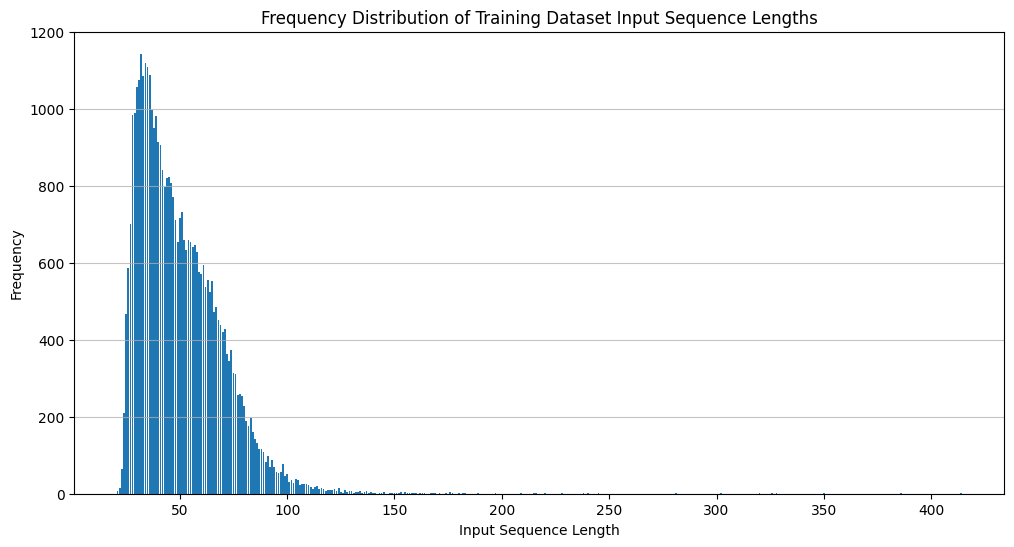

In [29]:
def plot_freq(freq):
    """Optimized - removed unnecessary sorting of already sorted dict"""
    lengths = list(freq.keys())
    frequencies = list(freq.values())

    plt.figure(figsize=(12, 6))
    plt.bar(lengths, frequencies)
    plt.xlabel("Input Sequence Length")
    plt.ylabel("Frequency")
    plt.title("Frequency Distribution of Training Dataset Input Sequence Lengths")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

plot_freq(freq)

In [30]:
import numpy as np

def top_k_freq(freq, k):
    """
    Optimized and fixed bug (k should be 0-1 range, not percentage)
    """
    total_examples = sum(freq.values())
    cumulative_freq = 0

    for length, count in freq.items():
        cumulative_freq += count
        if cumulative_freq >= k * total_examples:
            print(f"Sequence length covering {k*100:.0f}% of data: {length}")
            return length

In [31]:
top_k_freq(freq, .99)
top_k_freq(freq, .90)
top_k_freq(freq, .50)

Sequence length covering 99% of data: 107
Sequence length covering 90% of data: 75
Sequence length covering 50% of data: 46


46

99% tokens have length of 107. To round up near whole number for making GPU happy, Lets use context length of 128.

### Setting max_length=128

In [32]:
# setting max_seq_length for target 99%
from functools import partial

# Use partial with tokenize_with_labels and set max_length, padding, and truncation
final_tok_func = partial(tokenize_func,
                         max_length=128,
                         padding="max_length", # Pad to max_length
                         truncation=True)

ds = ds.map(final_tok_func)
ds

Map:   0%|          | 0/40639 [00:00<?, ? examples/s]

Dataset({
    features: ['nl', 'bash', 'full_text', 'label_text', 'instruct_text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 40639
})

### Removing un-wanted columns

To keep dataset lean or memory efficient

In [33]:
ds = ds.remove_columns(['nl', 'bash', 'full_text', 'label_text', 'instruct_text',])
ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 40639
})

### Train Test spliting

We will be splitting the data  90:5:5 for training:testing:validation respectively.

In [ ]:
# First split: 90% train, 10% temp (for valid and test)
train_testvalid = ds.train_test_split(test_size=0.1, seed=42)
train_ds = train_testvalid['train']
testvalid_ds = train_testvalid['test']

# Second split: Split the 10% temp into 50% valid and 50% test (which is 5% of original)
test_valid = testvalid_ds.train_test_split(test_size=0.5, seed=42)
valid_ds = test_valid['train']
test_ds = test_valid['test']

assert len(train_ds) + len(valid_ds) + len(test_ds) == len(ds)

In [35]:
ds = DatasetDict({
    'train' : train_ds,
    'valid' : valid_ds,
    'test' : test_ds
    })
ds

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 36575
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2032
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2032
    })
})

In [36]:
# for checking if the student model share embedding and lm head weught
student_model.model.embed_tokens.weight is student_model.lm_head.weight

True

## data collator


In [37]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

## Training

1. We will use HF trainer for model training task.
1. Use variable learning rate for Training different for embedding and decoder block. Which can be configured with the Optimizer.
1. And for gradual freezing and unfreezing we will use callbacks.

### Hyper-Prams

In [38]:
# Hyperparameters for different distillation factors (compression levels)
# Each factor determines how many teacher layers are condensed into one student layer
hyperparams = {
    2: {  # Less compression: 12 student layers
        'epochs': 4,                    # Number of complete passes through training data
        'decoder_lr': 4e-5,             # Learning rate for decoder layers
        'embed_lr': 1e-6,               # Learning rate for embedding layer (kept smaller to preserve teacher's vocabulary knowledge)
        'weight_decay': 0.01            # L2 regularization to prevent overfitting
    },
    3: {  # Medium compression: 8 student layers
        'epochs': 6,
        'decoder_lr': 6e-5,
        'embed_lr': 3e-6,
        'weight_decay': 0.015
    },
    4: {  # More compression: 6 student layers
        'epochs': 5,
        'decoder_lr': 2e-4,             # Higher LR needed as model has fewer layers to learn
        'embed_lr': 1e-6,
        'weight_decay': 0.001
    },
    6: {  # Most compression: 4 student layers (your current setting)
        'epochs': 4,
        'decoder_lr': 5e-4,             # Highest LR for most compressed model
        'embed_lr': 1e-6,
        'weight_decay': 0.001
    }
}

# Extract hyperparameters for current distillation factor
epochs = hyperparams[DISTIL_FACTOR]['epochs']
decoder_lr = hyperparams[DISTIL_FACTOR]['decoder_lr']
embed_lr = hyperparams[DISTIL_FACTOR]['embed_lr']
weight_decay = hyperparams[DISTIL_FACTOR]['weight_decay']

## Training configuration
log_interval = eval_steps = 20      # Log metrics and evaluate every 20 steps
save_steps = 20                     # Save checkpoint every 20 steps
save_total_limit = 2                # Keep only 2 most recent checkpoints to save disk space
bs = 32                             # Batch size: number of examples per training step
accum = 4                           # Gradient accumulation steps: effective batch size = bs * accum = 128

### Optimizer

We'll use **AdamW** optimizer with three parameter groups, each with different learning rates and weight decay settings:

1. **Embedding layers** (`embed_tokens` and `lm_head`):
   - Learning rate: `embed_lr` (very small, e.g., 1e-6)
   - Weight decay: 0 (frozen knowledge from teacher)
   - Rationale: Already well-trained, just need minor fine-tuning

2. **Decoder layers** (transformer blocks):
   - Learning rate: `decoder_lr` (higher, e.g., 5e-4)
   - Weight decay: `weight_decay` (e.g., 0.001)
   - Rationale: Main area for learning; needs regularization to prevent overfitting

3. **Other parameters** (layer norms, etc.):
   - Learning rate: `decoder_lr` (same as decoder)
   - Weight decay: 0 (no regularization needed)
   - Rationale: Support structures that adapt with decoder


In [39]:
def get_optimizer(model, decoder_lr=5e-5, embed_lr=1e-7, weight_decay=0.01):
    embed_params, decoder_weights, no_decays = [], [], []

    for name, param in model.named_parameters():
        # Check if 'embed' or 'lm_head' is in the name
        # as embedding and lm_head is already tied would be handled by the embedding layer
        if 'lm_head' in name:
            continue
        elif 'embed' in name :
            embed_params.append(param)
        # Check if 'bias' or 'norm' is in the name
        elif 'bias' in name or 'norm' in name:
            no_decays.append(param)
        else:
            decoder_weights.append(param)

    # check total no of params in model wrt the optimizer list
    total_in_groups = sum(p.numel() for p in embed_params) + sum(p.numel() for p in decoder_weights) + sum(p.numel() for p in no_decays)
    total_model = sum(p.numel() for p in student_model.parameters())
    assert total_in_groups == total_model
    print(f"{embed_lr=}, {decoder_lr=}, {weight_decay=}")
    param_groups = [
        {'params': decoder_weights, 'lr': decoder_lr, 'weight_decay': weight_decay, 'name': 'decoder'},
        {'params': embed_params, 'lr': embed_lr, 'weight_decay': 0.0, 'name': 'embedding'},
        {'params': no_decays, 'lr': decoder_lr, 'weight_decay': 0.0, 'name': 'bias'},

    ]
    return torch.optim.AdamW(param_groups)

optimizer = get_optimizer(student_model, decoder_lr, embed_lr, weight_decay)
optimizer

embed_lr=1e-06, decoder_lr=0.0005, weight_decay=0.001


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    name: decoder
    weight_decay: 0.001

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-06
    maximize: False
    name: embedding
    weight_decay: 0.0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    name: bias
    weight_decay: 0.0
)

### Callbacks

#### FreezingCallback (fast.ai-inspired gradual unfreezing)

Following fast.ai's transfer learning approach, we progressively unfreeze layers to prevent catastrophic forgetting of the teacher model's knowledge.

**Epoch 0**: Train upper layers while preserving foundation
- **Embeddings**: Frozen (maintains tokenizer consistency with teacher)
- **Layer 0**: Frozen (direct copy from teacher, serves as stable foundation)
- **Layers 1-3**: Training (adapt to bash command generation task)

**Epoch 1+**: Enable end-to-end fine-tuning
- **Embeddings**: Remain frozen (no benefit observed from unfreezing)
- **Layer 0**: Unfrozen (faster convergence with full model fine-tuning)
- **Layers 1-3**: Continue training

This mimics fast.ai's discriminative fine-tuning, where lower layers (closer to input) train with smaller learning rates or are unfrozen later to preserve learned features.


In [40]:
def set_embedding_trainable(model, trainable=False):
    #for param in model.model.embed_tokens.parameters():
    #    param.requires_grad = trainable
    model.model.embed_tokens.requires_grad_(trainable)

def set_decoder_layers_trainable(model, idx=0, trainable=False):
    model.model.layers[idx].requires_grad_(trainable)

In [41]:
set_embedding_trainable(student_model, False)
set_decoder_layers_trainable(student_model, 0, False)

In [42]:
# Check the requires_grad attribute of the parameters within the embedding layer
for param in student_model.model.embed_tokens.parameters():
    assert not param.requires_grad

In [43]:
for name, param in student_model.model.layers[0].named_parameters():
    assert not param.requires_grad

In [44]:
from transformers import TrainerCallback

class FreezingCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        current_epoch = int(state.epoch)
        model = kwargs.get('model')

        if current_epoch == 0:
            # freeze the embedding layer
            set_embedding_trainable(model, False)
            set_decoder_layers_trainable(model, 0, False)

        elif current_epoch == 1:
            set_decoder_layers_trainable(model, 0, True)

#### LearningRateUpdateCallback

From 3rd epoch, for finding best solution and numerical stability. This callback updates the learning rates
1. **Embeddings**: 1e-8
1. **Decoder and bias**: 1e-6

In [45]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import math

class LearningRateUpdateCallback(TrainerCallback):

    def on_epoch_begin(self, args, state, control, **kwargs):
        current_epoch = int(state.epoch)

        if current_epoch == 3:
            return control
            optim = kwargs.get('optimizer')

            # Update learning rates
            for group in optim.param_groups:
                name = group.get('name', '')
                new_lr = 1e-8 if name == 'embedding' else 1e-6
                group['lr'] = new_lr
                group['initial_lr'] = new_lr

            # Update the scheduler's base learning rates
            lr_scheduler = kwargs.get('lr_scheduler')
            if hasattr(lr_scheduler, 'base_lrs'):
                lr_scheduler.base_lrs = [group['lr'] for group in optim.param_groups]

            # Calculate remaining steps
            total_steps = state.max_steps
            current_step = state.global_step
            remaining_steps = total_steps - current_step
            #print(f"{current_epoch=} : {total_steps=}, {current_step=}, {remaining_steps=}")

            # Create new cosine scheduler for remaining steps
            new_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optim,
                T_max=remaining_steps,
                eta_min=0
            )

            # Update trainer's scheduler directly
            trainer = kwargs.get('trainer')
            if trainer is not None:
                trainer.lr_scheduler = new_scheduler

        return control

### Trainer

Few pointers for TrainingArg


1. **Gradient checkpointing**: it trades computation for memory by recomputing activations during backward pass instead of storing them.

1. **Cosine LR scheduler with warmup ratio (0.4)**: relatively high - it helps prevent early instability when training with high learning rates (especially for the 6x distillation factor).
1. **Effective batch size**: `bs * accum = 32 * 4 = 128`  actual batch size per update.

1. **Evaluation metric**: `load_best_model_at_end=True` is set, find best model wrt the eval_loss

1. **max_grad_norm** : Gradient clipping at 1.0 for stabilizing training process


1. **Mixed precision**: The fp16/bf16 setup based on hardware support - reduces memory and speeds up training.





In [46]:
bs, epochs, accum, log_interval, save_steps

(32, 4, 4, 20, 20)

In [47]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./qwen2.5-0.5B-Coder-Instruct",
    num_train_epochs=epochs,
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    gradient_accumulation_steps=accum,

    #max_steps = 1,
    learning_rate=5e-5,
    weight_decay=0.01,
    max_grad_norm=1.0,

    # Mixed precision
    fp16=torch.cuda.is_bf16_supported() == False,
    bf16=torch.cuda.is_bf16_supported(),

    # Logging
    logging_dir="./logs",

    # Saving
    save_steps=save_steps,
    save_total_limit=2,
    load_best_model_at_end=True,

    # Optimization
    lr_scheduler_type='cosine',
    warmup_ratio=0.4,
    optim="adamw_torch",

    # Other
    report_to="none",

    eval_strategy="steps",
    eval_steps=log_interval,

    logging_strategy="steps",
    logging_steps=log_interval,

    dataloader_drop_last=False, # For not dropping the last dataloder

)

In [48]:
%%bash
export TRACKIO_PROJECT_NAME=f"qwen2.5-distillation-by-{DISTIL_FACTOR}"
export TRACKIO_SPACE_ID="tripathysagar/trackio"

In [49]:
import trackio as wandb
training_args.report_to = "trackio"

In [50]:

trainer = Trainer(
    model=student_model,
    args=training_args,

    train_dataset=ds['train'],
    eval_dataset=ds['valid'],
    data_collator=data_collator,
    optimizers=(optimizer, None),
    callbacks=[FreezingCallback(), LearningRateUpdateCallback()],
)

trainer.train()

* Trackio project initialized: huggingface
* Trackio metrics will be synced to Hugging Face Dataset: tripathysagar/trackio-dataset
* Found existing space: https://huggingface.co/spaces/tripathysagar/trackio
* View dashboard by going to: https://tripathysagar-trackio.hf.space/


* Created new run: tripathysagar-1762795604


Step,Training Loss,Validation Loss
20,13.471800,9.079951
40,6.781100,4.982349
60,4.313300,3.746373
80,3.524300,3.230717
100,3.154500,3.037287
120,2.882600,2.753169
140,2.615000,2.516197
160,2.482600,2.412211
180,2.291700,2.253768
200,2.214200,2.177602


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


* Run finished. Uploading logs to Trackio (please wait...)


TrainOutput(global_step=1144, training_loss=1.8612987501221103, metrics={'train_runtime': 1482.8105, 'train_samples_per_second': 98.664, 'train_steps_per_second': 0.772, 'total_flos': 6702227098828800.0, 'train_loss': 1.8612987501221103, 'epoch': 4.0})

## Evalution on Test Set

In [51]:
eval_results = trainer.evaluate(ds['test'])
wandb.log({"test_results": eval_results})
eval_results

{'eval_loss': 1.3080734014511108,
 'eval_runtime': 6.996,
 'eval_samples_per_second': 290.45,
 'eval_steps_per_second': 4.574,
 'epoch': 4.0}

The model test loss is same as validation loss so we have not over fitted the model.

## Inference Examples After Training

In [62]:
test_infer("Search for a string 'OTP' in platform.log file.")
test_infer("list all the text files.")
test_infer("get kernel name.")
test_infer("create a new directory named 'my_folder'")
test_infer("change the permissions of 'script.sh' to be executable by everyone")
test_infer("list all files in the '/home' directory")
test_infer("copy file1.txt to file2.txt")
test_infer("remove a file named old_file.txt")
test_infer("display the content of the file named example.txt")
test_infer("change the current directory to '/usr/local'")
test_infer("create an empty file named 'newfile.txt'")
test_infer("list all files in the current directory that start with 'data'")

Search for a string 'OTP' in platform.log file. : grep -r 'otp'
list all the text files. : find . -name "*.txt" -exec echo {} \;
get kernel name. : uname -r
create a new directory named 'my_folder' : mkdir my_folder
change the permissions of 'script.sh' to be executable by everyone : find script.sh -type f -exec chmod +x script.sh \;
list all files in the '/home' directory : find /home -type f -exec ls -l {} \;
copy file1.txt to file2.txt : cp file1.txt file2.txt file3.txt file2.txt
remove a file named old_file.txt : find old_file.txt -name new_file.txt -exec rm {} \;
display the content of the file named example.txt : cat example.txt
change the current directory to '/usr/local' : cd $(find /usr/local -type d)
create an empty file named 'newfile.txt' : touch newfile.txt
list all files in the current directory that start with 'data' : find . -name 'data*' -print




**✅ Correct commands:**



- `uname -r` (kernel name)
- `mkdir my_folder`
- `cat example.txt`
- `touch newfile.txt`
- `find . -name 'data*' -print`

**⚠️ Overly complex but functional:**


- Using `find` with `-exec` when simpler commands would work
- Example: `find . -name "*.txt" -exec echo {} \;` could just be `ls *.txt`

**❌ Still has errors:**


- `cp file1.txt file2.txt file3.txt file2.txt` (duplicate file2.txt)
- `find old_file.txt -name new_file.txt -exec rm {} \;` (wrong logic - searching for new_file inside old_file)
- `cd $(find /usr/local -type d)` (would fail with multiple directories)


## Publishing to HF

In [53]:
def count_params(model):
    return float(sum([param.numel() for param in model.parameters()]))
count_params(teacher_model), count_params(student_model)

(494032768.0, 195785088.0)

In [ ]:
repo_name = "tripathysagar/Qwen2.5-Coder-196M-Shell"
# Push the model and tokenizer to the Hugging Face Hub
#student_model.push_to_hub(repo_name)
#tokenizer.push_to_hub(repo_name)

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...w4o8t5l/model.safetensors:   9%|8         | 33.5MB /  392MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mpyvk2dnlt/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/tripathysagar/Qwen2.5-Coder-196M-Shell/commit/540c201c181317129eddd5c7f5fb194076b4bae4', commit_message='Upload tokenizer', commit_description='', oid='540c201c181317129eddd5c7f5fb194076b4bae4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tripathysagar/Qwen2.5-Coder-196M-Shell', endpoint='https://huggingface.co', repo_type='model', repo_id='tripathysagar/Qwen2.5-Coder-196M-Shell'), pr_revision=None, pr_num=None)

## Conclusion

**What We Achieved**

We successfully distilled the Qwen2.5-Coder-0.5B-Instruct model (494M parameters, 24 layers) down to a compact 196M parameter model with just 4 decoder layers - a **6x compression** in layer count while retaining ~40% of the parameters. The goal was to extract the bash command generation capability into a specialized, CPU-friendly model.

**Training Journey**

The training showed excellent convergence over 4 epochs (1,144 steps):

- **Starting point**: Validation loss of ~9.08 (the model was essentially random)
- **Steady improvement**: Loss decreased consistently through epochs 1-2, reaching ~1.54 by step 600
- **Fine-tuning phase**: From epoch 3 onwards (step 860+), validation loss plateaued around **1.31**, while training loss dropped to **0.75**
- **Final gap**: The small train-val gap (~0.5) indicates good generalization with minimal overfitting

The sharp drop in training loss around step 880 (from ~1.13 to ~0.82) coincided with our learning rate reduction in epoch 3, showing the model was able to fine-tune effectively for the specialized task.

**Model Performance**

The distilled model generates bash commands with mixed results:
1. for simple command model works nicely
1. the model sometimes over complicates and return invalid command
**Overall**: The model shows it has learned bash syntax and basic command structure, but struggles with command simplicity and edge case logic.

**Limitations**

1. **Context length**: We truncated at 128 tokens, which handles 99% of the dataset but may struggle with very complex queries
2. **Initialization strategy**: We used simple layer copying (every 6th layer). The fused layers approach might have preserved more knowledge
3. **Generation quality**: While functional, the model occasionally produces suboptimal or incorrect commands
4. **Single-task focus**: The model is specialized for bash commands only - it lost the teacher's broader coding capabilities

### Future Improvements

Several avenues for enhancement:

1. **More training data**: The 40K examples might be limiting - synthetic data generation could help
1. **Post-training refinement**: Add a second phase with harder examples or use reinforcement learning with execution feedback
1. **KL-Loss**: Using KL loss i.e. directly learning from the logits of teacher model

### Final Thoughts

This distillation experiment demonstrates that knowledge can be successfully transferred from a larger instruct-tuned model to a compact, specialized variant. The 196M model is **2.5x smaller** than the teacher and much more practical for CPU deployment or edge devices. While there's room for improvement in command quality, the approach proves viable for creating domain-specific models from general-purpose foundations.

The key insight: **specialized compression works** - by focusing on a narrow task (bash generation), we retained useful capabilities while dramatically reducing model size.



## Acknowledgments

1. This project was developed using [solve.it](https://solve.it/), which provided an excellent platform for experimentation, data preparation, model architecture design, and inference testing. Please check out the new way of literal programming.
1. The actual model training was conducted on Google Colab to leverage GPU resources.